In [31]:
!pip install xlrd
!pip install xgboost

  Using cached xgboost-2.0.3-py3-none-macosx_12_0_arm64.whl.metadata (2.0 kB)
Using cached xgboost-2.0.3-py3-none-macosx_12_0_arm64.whl (1.9 MB)


In [3]:
import pandas as pd

In [6]:
df = pd.read_excel('credit_default_dataset.xls')

In [7]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Data Preprocessing Steps:

In [8]:
#removing unnecessary columns
df = df.drop(['ID'], axis = 1)

In [9]:
#renaming columns for better readability as PAY_1 is missing(correcting numbering)
df.rename(columns = {'PAY_0':'PAY_1'}, inplace = True)

In [10]:
df.head(2)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   SEX                         30000 non-null  int64
 2   EDUCATION                   30000 non-null  int64
 3   MARRIAGE                    30000 non-null  int64
 4   AGE                         30000 non-null  int64
 5   PAY_1                       30000 non-null  int64
 6   PAY_2                       30000 non-null  int64
 7   PAY_3                       30000 non-null  int64
 8   PAY_4                       30000 non-null  int64
 9   PAY_5                       30000 non-null  int64
 10  PAY_6                       30000 non-null  int64
 11  BILL_AMT1                   30000 non-null  int64
 12  BILL_AMT2                   30000 non-null  int64
 13  BILL_AMT3                   30000 non-null  int64
 14  BILL_A

Target will be a binary variable, default payment (Yes = 1, No = 0), as the response variable. 
This study reviewed the literature and used the following 23 variables as explanatory variables:

1. X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
2. X2: Gender (1 = male; 2 = female).
3. X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
4. X4: Marital status (1 = married; 2 = single; 3 = others).
5. X5: Age (year).
6. X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: 
    X6 = the repayment status in September, 2005; 
    X7 = the repayment status in August, 2005; . . .;
    X11 = the repayment status in April, 2005. 
    The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
7. X12-X17: Amount of bill statement (NT dollar). 
    X12 = amount of bill statement in September, 2005; 
    X13 = amount of bill statement in August, 2005; . . .; 
    X17 = amount of bill statement in April, 2005. 
8. X18-X23: Amount of previous payment (NT dollar). 
    X18 = amount paid in September, 2005; 
    X19 = amount paid in August, 2005; . . .;
    X23 = amount paid in April, 2005.

In [8]:
# Observing varible irregularities

df['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

#### The EDUCATION Variable was initially given 4 categories but in the dataset there are more undefined categories which needs to be updated.

In [9]:
df['EDUCATION'] = df['EDUCATION'].map({0:4,1:1,2:2,3:3,4:4,5:4,6:4})

In [10]:
df['MARRIAGE'].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

#### The MARRIAGE Variable was given 3 categories but in the dataset there are more undefined categories which needs to be updated.

In [11]:
df['MARRIAGE'] = df['MARRIAGE'].map({0:3,1:1,2:2,3:3})

In [12]:
# updating column name for better readability
df.rename(columns={"default payment next month": "default_next_month"}, inplace=True)


### Checking for null values

In [14]:
df.isnull().sum()

LIMIT_BAL             0
SEX                   0
EDUCATION             0
MARRIAGE              0
AGE                   0
PAY_1                 0
PAY_2                 0
PAY_3                 0
PAY_4                 0
PAY_5                 0
PAY_6                 0
BILL_AMT1             0
BILL_AMT2             0
BILL_AMT3             0
BILL_AMT4             0
BILL_AMT5             0
BILL_AMT6             0
PAY_AMT1              0
PAY_AMT2              0
PAY_AMT3              0
PAY_AMT4              0
PAY_AMT5              0
PAY_AMT6              0
default_next_month    0
dtype: int64

## Exploring Dataset and Relation between the attributes

### 1. Descriptive statistics for numerical variables

In [15]:
# Descriptive statistics for numerical variables
print("\nDescriptive statistics for numerical variables:")
df.describe()


Descriptive statistics for numerical variables:


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_next_month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


### 2. Checking if the dataset is balanced or not.

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of the target variable
print("\nDistribution of the target variable:")
print(df['default_next_month'].value_counts())

# Calculate percentages
total_samples = len(df)
counts = df['default_next_month'].value_counts()
percentages = counts / total_samples * 100

# Visualizations
plt.figure(figsize=(10, 6))
ax = sns.countplot(df['default_next_month'], order=counts.index)
plt.title('Distribution of Default Payment')
plt.xlabel('Default Payment (1 = Yes, 0 = No)')
plt.ylabel('Count')

# Annotate each bar with its percentage
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 0.5,
            f'{percentages[i]:.2f}%',
            ha="center")

plt.show()


Distribution of the target variable:
default_next_month
0    23364
1     6636
Name: count, dtype: int64


ValueError: Input data must be a pandas object to reorder

<Figure size 1000x600 with 0 Axes>

### 3. Relationship between Categorical variables with target variable

ValueError: Could not interpret input 'default.payment.next.month'

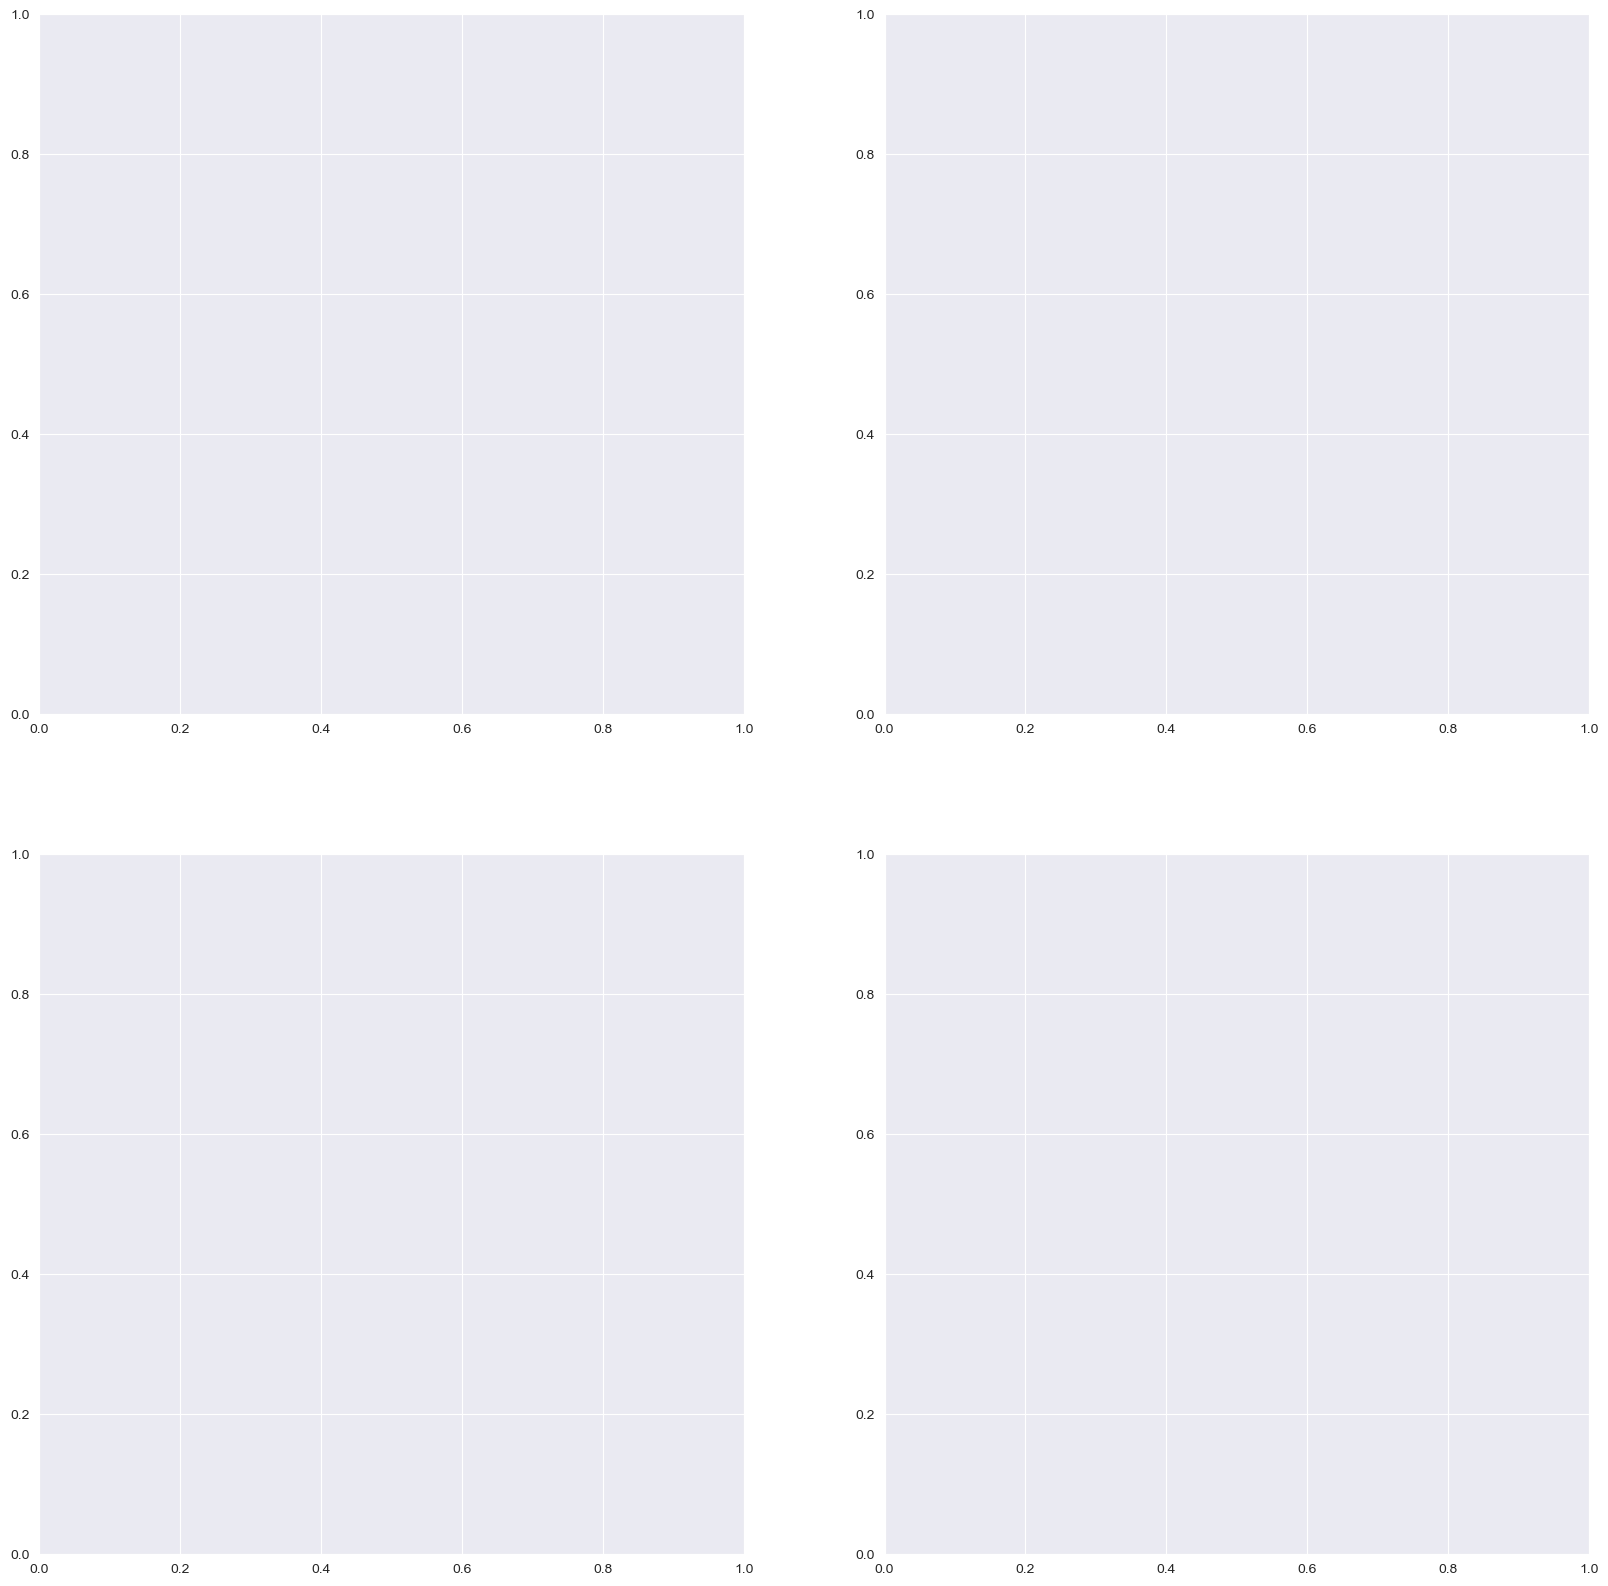

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define age groups
age_bins = [20, 30, 40, 50, 60, 70, 80]
age_labels = ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79']

# Add a new column to the DataFrame indicating the age group
df['AGE_GROUP'] = pd.cut(df['AGE'], bins=age_bins, labels=age_labels, right=False)

# Define the features you want to visualize
features = ['SEX', 'EDUCATION', 'MARRIAGE', 'AGE_GROUP']

# Set up the figure and axes
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over each feature and create subplots
for i, feature in enumerate(features):
    sns.countplot(x=feature, hue='default_next_month', data=df, ax=axes[i])
    axes[i].set_title('Relationship between {} and Default Payment'.format(feature))
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    axes[i].legend(title='Default Payment', loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()

### 4. Exploring repayment status variables and how they relate to target variable

AttributeError: 'numpy.int64' object has no attribute 'startswith'

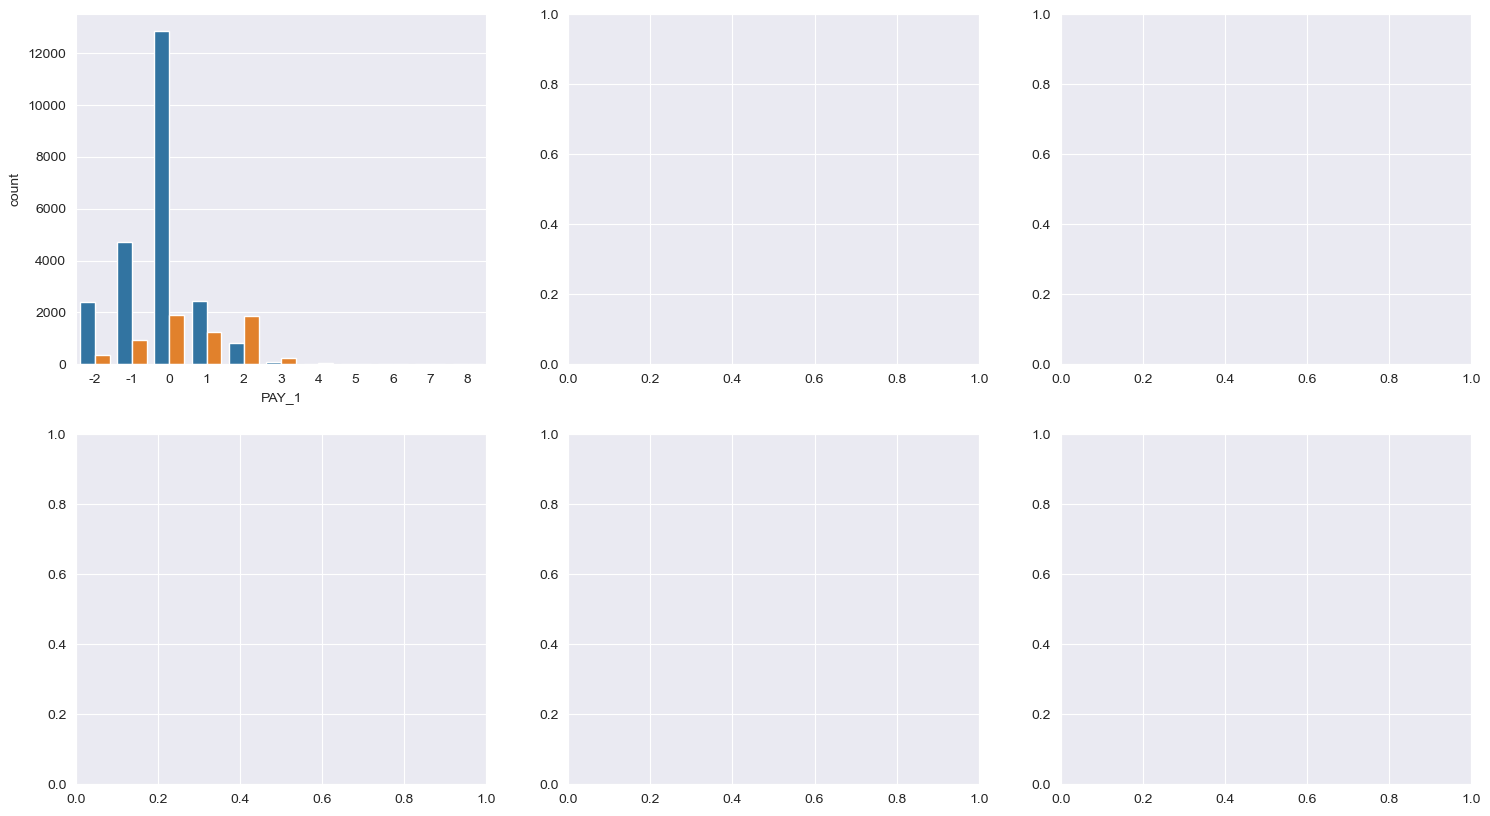

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define mapping for repayment status labels
repayment_status_labels = {
    -2: 'No Consumption',
    -1: 'Paid in Full',
    0: 'Revolving Credit',
    1: 'Payment Delay 1 Month',
    2: 'Payment Delay 2 Months',
    3: 'Payment Delay 3 Months',
    4: 'Payment Delay 4 Months',
    5: 'Payment Delay 5 Months',
    6: 'Payment Delay 6 Months',
    7: 'Payment Delay 7 Months',
    8: 'Payment Delay 8 Months',
    9: 'Payment Delay 9+ Months'
}

# Exploring Repayment Status (PAY_0 to PAY_6) with subplots
repayment_status_vars = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 10))

for i, var in enumerate(repayment_status_vars):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    sns.countplot(x=var, hue='default_next_month', data=df, ax=ax)
    ax.set_title('Distribution of {} by Default Payment'.format(var))
    ax.set_xlabel(var)
    ax.set_ylabel('Count')
    ax.set_xticklabels([repayment_status_labels[val] for val in sorted(df[var].unique())], rotation=45, ha='right')
    ax.legend(title='Default Payment', loc='upper right')

plt.tight_layout()
plt.show()


### 5. Analyzing Bill Amounts & Payment Amounts

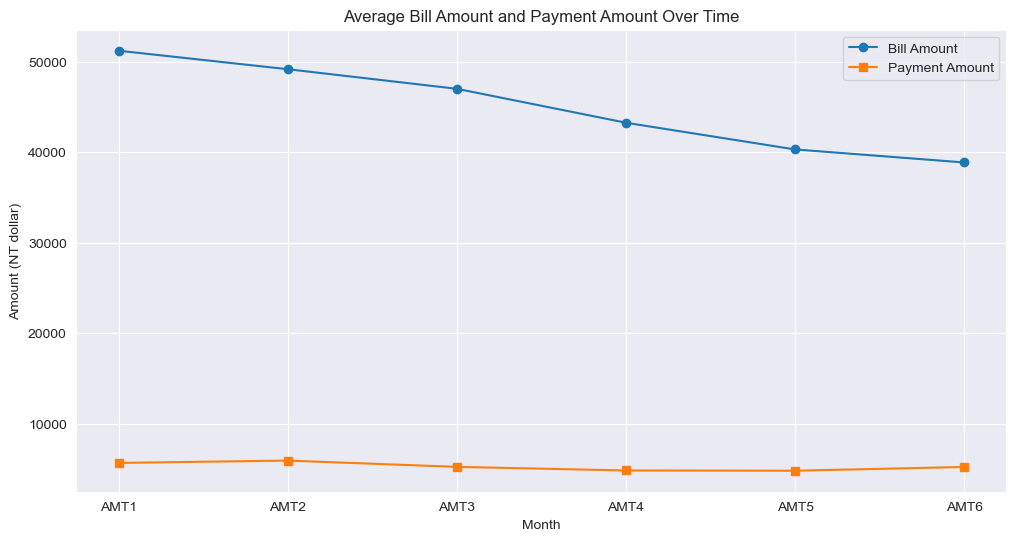

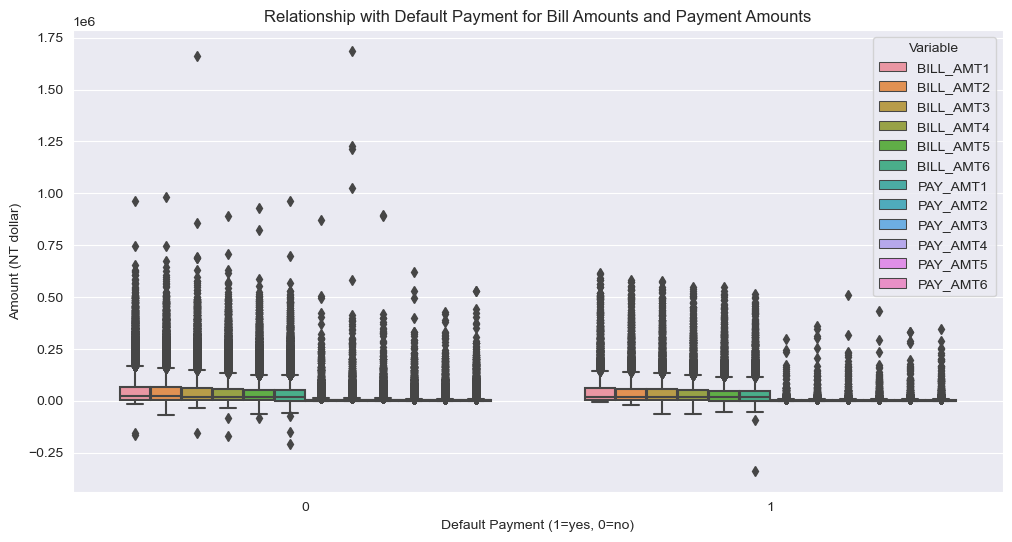

In [24]:
# Exploring Bill Amounts (BILL_AMT1 to BILL_AMT6) and Payment Amounts (PAY_AMT1 to PAY_AMT6)
bill_amt_vars = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
pay_amt_vars = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# Summary statistics for bill amounts
#print("Summary Statistics for Bill Amounts:")
#print(df[bill_amt_vars].describe())

# Summary statistics for payment amounts
#print("\nSummary Statistics for Payment Amounts:")
#print(df[pay_amt_vars].describe())

# Trend analysis for bill amounts and payment amounts
plt.figure(figsize=(12, 6))
df[bill_amt_vars].mean().plot(marker='o', label='Bill Amount')
df[pay_amt_vars].mean().plot(marker='s', label='Payment Amount')
plt.title('Average Bill Amount and Payment Amount Over Time')
plt.xlabel('Month')
plt.ylabel('Amount (NT dollar)')
plt.xticks(range(len(bill_amt_vars)), [var.split('_')[1] for var in bill_amt_vars])
plt.legend()
plt.grid(True)
plt.show()

# Relationship with default payment for bill amounts and payment amounts
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[bill_amt_vars + pay_amt_vars + ['default_next_month']].melt(id_vars='default_next_month'), 
            x='default_next_month', y='value', hue='variable')
plt.title('Relationship with Default Payment for Bill Amounts and Payment Amounts')
plt.xlabel('Default Payment (1=yes, 0=no)')
plt.ylabel('Amount (NT dollar)')
plt.legend(title='Variable', loc='upper right')
plt.show()

### 6. Correlation Matrix

In [25]:
import numpy as np

# Compute the correlation matrix
correlation_matrix = df.corr()

# Create a mask to only show the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 6})
plt.title('Correlation Matrix (Upper Triangle)')
plt.show()

ValueError: could not convert string to float: '20-29'

### 7. Correlation with target variable

In [26]:
# Extract correlations with the target variable
target_correlation = correlation_matrix['default_next_month'].drop('default_next_month')

# Sort correlations in descending order
target_correlation = target_correlation.sort_values(ascending=False)

# Print correlations
#print("Correlation with target variable:")
#print(target_correlation)

# Plot correlations with the target variable
plt.figure(figsize=(10, 6))
sns.barplot(x=target_correlation.index, y=target_correlation.values, palette='coolwarm')
plt.title('Correlation with Target Variable')
plt.xlabel('Numerical Variables')
plt.ylabel('Correlation')
plt.xticks(rotation=45, ha='right')
plt.show()


NameError: name 'correlation_matrix' is not defined

## Model Running

In [27]:
# scaling down to same unit
from sklearn.preprocessing import StandardScaler
scaling = StandardScaler()

X = df.drop(['default_next_month', 'AGE_GROUP'],axis =1)

X = scaling.fit_transform(X)

In [28]:
y = df['default_next_month']

In [29]:
## Hyper Parameter optimization

params = {
    "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    "max_depth"        : [3, 4, 5, 6, 8, 10, 12, 15],
    "min_child_weight" : [1, 3, 5, 7],
    "gamma"            : [0.0, 0.1, 0.2, 0.3, 0.4],
    "colsample_bytree" : [0.3, 0.4, 0.5, 0.7]
    
}

In [32]:
## Hyperparameter optimization using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
import xgboost

In [33]:
def timer(start_time = None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' %(thour, tmin, round(tsec, 2)))

In [34]:
classifier = xgboost.XGBClassifier()

In [35]:
random_search = RandomizedSearchCV(classifier, param_distributions = params, n_iter=5, scoring ='roc_auc', n_jobs=-1, cv=5, verbose =3)

In [36]:
from datetime import datetime

start_time = timer(None)
random_search.fit(X,y)
timer(start_time)

Fitting 5 folds for each of 5 candidates, totalling 25 fits

 Time taken: 0 hours 0 minutes and 3.07 seconds.


In [37]:
random_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [38]:
classifier = xgboost.XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=7, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None)

In [39]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(classifier, X, y, cv = 10)

In [40]:
score

array([0.80633333, 0.808     , 0.81533333, 0.80633333, 0.81833333,
       0.824     , 0.83966667, 0.83      , 0.82666667, 0.82166667])

In [41]:
score.mean()

0.8196333333333333

In [42]:
!pip install imbalanced-learn

In [43]:
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import numpy as np

# SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# XGBoost model with hyperparameter tuning
xgb_classifier = XGBClassifier(random_state=42)

# Hyper-parameter Tuning
print("Hyper-parameter Tuning:")
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Model Evaluation and Validation
print("\nModel Evaluation and Validation:")
xgb_classifier = XGBClassifier(**best_params, random_state=42)
xgb_scores = cross_val_score(xgb_classifier, X_resampled, y_resampled, cv=10, scoring='roc_auc')

print("Cross-Validation ROC-AUC Scores:", xgb_scores)
print("Mean ROC-AUC Score:", np.mean(xgb_scores))


Hyper-parameter Tuning:
Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 1.0}

Model Evaluation and Validation:
Cross-Validation ROC-AUC Scores: [0.76870153 0.79547105 0.79935053 0.98170384 0.98419695 0.97903991
 0.98568095 0.98732331 0.98520203 0.98698757]
Mean ROC-AUC Score: 0.9253657663731583


In [44]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import numpy as np

# SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Random Forest model with hyperparameter tuning
rf_classifier = RandomForestClassifier(random_state=42)


# Hyper-parameter Tuning
print("Hyper-parameter Tuning:")
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Model Evaluation and Validation
print("\nModel Evaluation and Validation:")
rf_classifier = RandomForestClassifier(**best_params, random_state=42)
rf_scores = cross_val_score(rf_classifier, X_resampled, y_resampled, cv=10, scoring='roc_auc')

print("Cross-Validation ROC-AUC Scores:", rf_scores)
print("Mean ROC-AUC Score:", np.mean(rf_scores))

Hyper-parameter Tuning:
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

Model Evaluation and Validation:
Cross-Validation ROC-AUC Scores: [0.85866702 0.87369963 0.8697924  0.96207791 0.96389886 0.9554583
 0.96711415 0.96989091 0.9689546  0.96354219]
Mean ROC-AUC Score: 0.9353095968901852


In [45]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define individual models
model1 = LogisticRegression()
model2 = DecisionTreeClassifier()
model3 = SVC(probability=True)  # SVC needs probability=True to enable probability prediction

# Create the hard voting classifier
hard_voting_clf = VotingClassifier(estimators=[('lr', model1), ('dt', model2), ('svc', model3)], voting='hard')

# Create the soft voting classifier
soft_voting_clf = VotingClassifier(estimators=[('lr', model1), ('dt', model2), ('svc', model3)], voting='soft')

# Train the voting classifiers
hard_voting_clf.fit(X_train, y_train)
soft_voting_clf.fit(X_train, y_train)

# Evaluate the models
hard_voting_accuracy = hard_voting_clf.score(X_test, y_test)
soft_voting_accuracy = soft_voting_clf.score(X_test, y_test)

print("Hard Voting Classifier Accuracy:", hard_voting_accuracy)
print("Soft Voting Classifier Accuracy:", soft_voting_accuracy)

[CV 3/5] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=5;, score=0.790 total time=   0.5s
[CV 4/5] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.15, max_depth=12, min_child_weight=1;, score=0.792 total time=   0.6s
[CV 5/5] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=5;, score=0.791 total time=   0.4s
[CV 5/5] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.3, max_depth=4, min_child_weight=7;, score=0.787 total time=   0.3s
[CV 3/5] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.05, max_depth=4, min_child_weight=3;, score=0.794 total time=   0.2s
[CV 4/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=4, min_child_weight=3;, score=0.802 total time=   0.2s
[CV 1/5] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.05, max_depth=4, min_child_weight=3;, score=0.756 total time=   0.3s
[CV 3/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.15, max_depth=4, min_ch

In [46]:
# Compare XGBoost and Random Forest models based on mean ROC-AUC scores
if np.mean(xgb_scores) > np.mean(rf_scores):
    print("XGBoost model performs better.")
else:
    print("Random Forest model performs better.")


Random Forest model performs better.


In [47]:
# Model Comparison
if hard_voting_accuracy > soft_voting_accuracy:
    print("Hard Voting Classifier performs better.")
else:
    print("Soft Voting Classifier performs better.")


Hard Voting Classifier performs better.


In [48]:
# Fit the best random forest model
rf_best_model.fit(X_resampled, y_resampled)

# Get feature importances
feature_importance = rf_best_model.feature_importances_
sorted_indices = np.argsort(feature_importance)[::-1]

# Display the top 10 most important features
top_features = 10
print(f"Top {top_features} Important Features:")
for i in range(top_features):
    print(f"{feature_names[sorted_indices[i]]}: {feature_importance[sorted_indices[i]]}")


NameError: name 'rf_best_model' is not defined

The output shows the top 10 important features along with their importance scores, as determined by the random forest model. Here's how to interpret it:

1. PAY_1 (Repayment status in September): This feature has the highest importance score, indicating that the repayment status in September has the strongest predictive power for determining credit default.
2. LIMIT_BAL (Credit limit): The credit limit is the second most important feature, suggesting that the amount of credit extended to the client also significantly influences the likelihood of default.
3. AGE: Age comes in as the third most important feature, indicating that the age of the client is also an important factor in predicting credit default.
4. BILL_AMT1 (Bill statement amount in September): The amount of the bill statement in September is also a relevant factor in determining credit default.
5. PAY_AMT1 (Amount paid in September): The amount paid in September towards the bill is another crucial feature, suggesting that the client's payment behavior in the previous month affects default probability.
6. PAY_AMT2 (Amount paid in August): Similar to PAY_AMT1, the amount paid in August is also an important predictor of credit default.
7. PAY_AMT6 (Amount paid in April): The amount paid in April contributes significantly to predicting credit default.
8. BILL_AMT2 (Bill statement amount in August): The bill statement amount in August is another relevant factor in determining default probability.
9. PAY_2 (Repayment status in August): Repayment status in August is also influential, indicating that the payment behavior in the previous month is critical for predicting default.
10. PAY_AMT3 (Amount paid in July): Finally, the amount paid in July rounds up the top 10 important features, suggesting that payment behavior in earlier months continues to be relevant for predicting default.

Overall, these features provide insights into the factors that contribute most to predicting credit default in the dataset.

### Interpretation:

